# Genetic search approach


In [1]:
import numpy as np
np.random.seed(420)

In [2]:
train_X = np.load('../data/train_X.npy')
train_y = np.load('../data/train_y.npy')
valid_X = np.load('../data/valid_X.npy')
valid_y = np.load('../data/valid_y.npy')

In [3]:
N = 1500  # dataset size
T = 16  # number of datasets per generation
M = 0.2  # fraction of dataset samples dropped during mutation phase

In [4]:
from typing import List, Tuple
from dataclasses import dataclass

@dataclass
class DataSet(object):
    X: np.array
    y: np.array
    ids: np.array
    
    @classmethod
    def combine(cls, ds1, ds2):
        assert(ds1.X.shape == ds2.X.shape)
        intersection = np.intersect1d(ds1.ids, ds2.ids)
        other = np.random.choice(
            np.setxor1d(ds1.ids, ds2.ids), len(ds1.ids)-len(intersection)
        )
        new_ids = np.concatenate([intersection, other])
        take_from_left = np.isin(ds1.ids, new_ids)
        take_from_right = np.isin(ds2.ids, new_ids)
        # new ids need to be re-ordered to match the order 
        # in which X and y are selected for the new DataSet:
        new_ids = np.select(
            [take_from_left, take_from_right],
            [ds1.ids, ds2.ids]
        )
        new_X = np.select(
            [
                np.repeat(take_from_left, ds1.X.shape[1]).reshape(ds1.X.shape),
                np.repeat(take_from_right, ds2.X.shape[1]).reshape(ds2.X.shape)
            ],
            [ds1.X, ds2.X]
        )
        new_y = np.select(
            [take_from_left, take_from_right],
            [ds1.y, ds2.y]
        )
        return cls(new_X, new_y, new_ids)
        

def sample_datasets(
        n_samples: int=N, 
        n_datasets: int=T, 
        n_validation_samples: int=10*N, 
        source_X: np.array=train_X, 
        source_y: np.array=train_y
) -> Tuple[List[DataSet], DataSet]:
    ids = [
        np.random.choice(
            len(source_X), 
            n_samples, 
            replace=False
        ) for i in range(n_datasets)
    ]
    rest_ids = np.array(list(set(range(len(source_X))) - set(list(np.concatenate(ids)))))
    validation_ids = np.random.choice(rest_ids, n_validation_samples)
    return [DataSet(source_X[i], source_y[i], i) for i in ids], DataSet(source_X[validation_ids], source_y[validation_ids], validation_ids)

In [5]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import r2_score

params_dict = {
    'kernel': ['rbf'],
    'gamma': [1 / i for i in range(80, 130, 10)],
    'C': [0.9, 1.0, 1.1],
    'epsilon': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1],
    'shrinking': [True]
}

def train_svr(train_set: DataSet, param_validation_set: DataSet, params_dict: dict=params_dict, n_iter: int=25):
    ps = ParameterSampler(n_iter=n_iter, param_distributions=params_dict)
    scores = np.zeros(n_iter)
    models = list()
    for idx, params in enumerate(ps):
        svr = SVR(**params)
        svr.fit(train_set.X, train_set.y)
        preds = svr.predict(param_validation_set.X)
        scores[idx] = r2_score(param_validation_set.y, preds)
        models.append(svr)
    return models[np.argmax(scores)]

def _train_one(tupl):
    ds, param_validation_set = tupl
    return train_svr(ds, param_validation_set)

In [6]:
def make_probabilities(weighted_sample_scores):
    # must modify sample scores to be nonnegative
    modified_sample_scores = np.exp(weighted_sample_scores)
    inversed_sample_scores = 1 / modified_sample_scores
    normalised_sample_scores = inversed_sample_scores / inversed_sample_scores.sum()
    # cut useless datasamples
    sorted_ids = np.argsort(normalised_sample_scores)
    cum_sum = np.cumsum(normalised_sample_scores[sorted_ids])
    to_zero_out_ids = sorted_ids[cum_sum < 0.5]
    normalised_sample_scores[to_zero_out_ids] = 0
    
    renormalised_sample_scores = normalised_sample_scores / normalised_sample_scores.sum()
    return renormalised_sample_scores

In [7]:
from tqdm import tqdm
from itertools import combinations
from math import ceil
from multiprocessing import Pool, Array

class VerboseMixin(object):
    def _progress(self, iterator, total):
        if self.verbose:
            return tqdm(iterator, total=total, desc=self.__class__.__name__)
        else:
            return iterator

    def _log(self, message):
        if self.verbose:
            print(f"[{self.__class__.__name__}] {message}")

class Evolution(VerboseMixin):
    def __init__(
            self, 
            T=T, 
            M=M,
            train_X=train_X, 
            train_y=train_y, 
            valid_X=valid_X, 
            valid_y=valid_y, 
            n_generations: int=100,
            n_workers: int=4,
            verbose: bool=False
    ):
        self.training_sets, self.param_validation_set = sample_datasets(n_datasets=T)
        self.entire_dataset = DataSet(train_X, train_y, np.arange(len(train_X)))
        self.model_validation_dataset = DataSet(valid_X, valid_y, None)
        self.n_generations = n_generations
        self.verbose = verbose
        self.M = M
        self.n_workers = n_workers

    def _train(self):
        
        sample_scores = np.zeros(
            (len(self.training_sets), len(self.entire_dataset.X))
        )  # sample_scores[model_id][sample] = model's uncertainty of this sample
        model_validation_scores = np.zeros(len(self.training_sets))
        model_params = list()
        

        print("Multiprocess training...")
        with Pool(processes=4) as pool:
            models = pool.map(_train_one, zip(self.training_sets, [self.param_validation_set] * len(self.training_sets)))
            
        print("Synchronization...")    
        for model_id, (ds, model) in self._progress(
                enumerate(zip(self.training_sets, models)), total=len(self.training_sets)
        ):
#             model = train_svr(ds, self.param_validation_set)
            preds = model.predict(self.entire_dataset.X)
            sample_scores[model_id] = np.abs(self.entire_dataset.y - preds)
            preds = model.predict(self.model_validation_dataset.X)
            model_validation_scores[model_id] = r2_score(self.model_validation_dataset.y, preds)
            model_params.append(model.get_params())
        return np.mean(sample_scores * model_validation_scores.reshape((-1,1)), axis=0), model_params, model_validation_scores
    
    def _select_sets(self, model_validation_scores: np.array):
        normalized_scores = model_validation_scores / np.sum(model_validation_scores)
        sorted_order = np.argsort(-normalized_scores)  # sort by DESCENDING SCORE
        self.training_sets = list(np.array(self.training_sets)[sorted_order])
        cum_scores = np.cumsum(normalized_scores[sorted_order])
        fitness_threshold = 0.
        while fitness_threshold < cum_scores[1]:
            fitness_threshold = np.random.random()
        fit_datasets = [
            ds for ds, is_fit 
            in zip(self.training_sets, cum_scores < fitness_threshold) 
            if is_fit
        ]
        return fit_datasets  # sorted by model score, descending
    
    def _crossover(self, fit_datasets: List[np.array]):
        new_datasets = []
        while len(new_datasets) < len(self.training_sets):
            # if there is a really small number of fit_datasets, 
            # we want to resample T new datasets from what we have
            for ds1, ds2 in combinations(fit_datasets, 2):
                new_datasets.append(DataSet.combine(ds1, ds2))
                if len(new_datasets) >= len(self.training_sets):
                    break
        self.training_sets = new_datasets
        
    def _mutate(self, sample_scores):
        new_datasets = []
        for ds in self.training_sets:
            ids = np.random.permutation(len(ds.X))
            num_of_dumped = ceil(len(ds.X) * self.M)
            chosen = ids[:-num_of_dumped]
            supplied = ds.ids[chosen]
            while len(np.intersect1d(ds.ids[chosen], supplied)) != 0:
                supplied = np.random.choice(np.arange(len(self.entire_dataset.X)), size=num_of_dumped, replace=False, p=sample_scores)
            new = DataSet(
                np.concatenate([ds.X[chosen], self.entire_dataset.X[supplied]]),
                np.concatenate([ds.y[chosen], self.entire_dataset.y[supplied]]),
                np.concatenate([ds.ids[chosen], supplied])
            )
            new_datasets.append(new)
        self.training_sets = new_datasets
            
                
    def __iter__(self):
        self.generation = 0
        return self
    
    def __next__(self):
        if self.generation >= self.n_generations:
            raise StopIteration()
        weighted_sample_scores, model_params, model_validation_scores = self._train()
        fit_datasets = self._select_sets(model_validation_scores)
        
        self._crossover(fit_datasets)
        probs = make_probabilities(weighted_sample_scores)
        print("Data probabilities variance:", probs[probs != 0].var())
        self._mutate(probs)
        self.generation += 1
        return model_validation_scores, probs

In [9]:
ev = Evolution(n_generations=20, verbose=True)
history = []
data = []
for scores, sample_probs in ev:
    print("Number of samples chosen to resample datasets:", len(sample_probs[sample_probs != 0]))
    history.append(scores)
    data.append(sample_probs)
    print("Mean model score:", scores.mean())

Training


Evolution: 100%|██████████| 16/16 [03:43<00:00, 13.13s/it]


1.0026838313604056e-10 0.0
49933
0.051391845372352724
Training


Evolution: 100%|██████████| 16/16 [02:58<00:00, 11.27s/it]


1.004530959540358e-10 0.0
49887
0.08537930619821889
Training


Evolution: 100%|██████████| 16/16 [02:24<00:00,  8.82s/it]


1.0056973689391041e-10 0.0
49858
0.10584387380374208
Training


Evolution: 100%|██████████| 16/16 [02:06<00:00,  7.81s/it]


1.0065027476283638e-10 0.0
49838
0.11956100139107564
Training


Evolution: 100%|██████████| 16/16 [01:59<00:00,  7.37s/it]


1.0066236612394062e-10 0.0
49835
0.12111176123127099
Training


Evolution: 100%|██████████| 16/16 [02:22<00:00,  8.01s/it]


1.0071475906625387e-10 0.0
49822
0.1304246397047065
Training


Evolution: 100%|██████████| 16/16 [02:12<00:00,  9.23s/it]


1.0073895103270418e-10 0.0
49816
0.13468358043164008
Training


Evolution: 100%|██████████| 16/16 [02:13<00:00,  9.19s/it]


1.0075104964394579e-10 0.0
49813
0.13617070567256545
Training


Evolution: 100%|██████████| 16/16 [02:24<00:00,  8.91s/it]


1.0077121821091044e-10 0.0
49808
0.1402041199047943
Training


Evolution: 100%|██████████| 16/16 [02:08<00:00,  8.28s/it]


1.0078332235725502e-10 0.0
49805
0.14183004073628386
Training


Evolution: 100%|██████████| 16/16 [02:18<00:00,  8.11s/it]


1.0081156787092237e-10 0.0
49798
0.14675690840698627
Training


Evolution: 100%|██████████| 16/16 [02:25<00:00,  8.91s/it]


1.0081963661235023e-10 0.0
49796
0.14868264911565005
Training


Evolution: 100%|██████████| 16/16 [02:14<00:00,  8.61s/it]


1.0080753092202038e-10 0.0
49799
0.14604526052423927
Training


Evolution: 100%|██████████| 16/16 [02:22<00:00,  9.23s/it]


1.0081963806427094e-10 0.0
49796
0.1481418298542892
Training


Evolution: 100%|██████████| 16/16 [02:26<00:00,  9.09s/it]


1.0080752861961063e-10 0.0
49799
0.1464605770859853
Training


Evolution: 100%|██████████| 16/16 [02:19<00:00,  8.62s/it]


1.0082770354865228e-10 0.0
49794
0.1496798833617404
Training


Evolution: 100%|██████████| 16/16 [02:17<00:00,  8.76s/it]


1.0083981230732397e-10 0.0
49791
0.15176874844136484
Training


Evolution: 100%|██████████| 16/16 [02:08<00:00,  7.97s/it]


1.0085596583720271e-10 0.0
49787
0.1543653599516722
Training


Evolution: 100%|██████████| 16/16 [02:12<00:00,  7.92s/it]


1.0083981681612976e-10 0.0
49791
0.15224168065245197
Training


Evolution: 100%|██████████| 16/16 [02:21<00:00,  8.23s/it]


1.0084385355562732e-10 0.0
49790
0.15228560592654664


49917


(array([6.123e+03, 5.272e+03, 4.444e+03, 4.124e+03, 3.688e+03, 3.073e+03,
        2.798e+03, 2.555e+03, 2.019e+03, 1.933e+03, 1.610e+03, 1.490e+03,
        1.246e+03, 1.076e+03, 9.630e+02, 8.840e+02, 7.400e+02, 6.520e+02,
        5.790e+02, 4.990e+02, 4.570e+02, 4.340e+02, 3.470e+02, 2.940e+02,
        2.920e+02, 2.460e+02, 2.270e+02, 1.910e+02, 1.670e+02, 1.560e+02,
        1.500e+02, 1.300e+02, 1.220e+02, 8.400e+01, 9.700e+01, 7.400e+01,
        6.800e+01, 5.000e+01, 4.100e+01, 4.000e+01, 3.800e+01, 3.800e+01,
        4.200e+01, 3.500e+01, 3.200e+01, 2.100e+01, 2.500e+01, 2.100e+01,
        3.000e+00, 1.600e+01, 9.000e+00, 1.100e+01, 7.000e+00, 1.200e+01,
        8.000e+00, 8.000e+00, 8.000e+00, 7.000e+00, 5.000e+00, 5.000e+00,
        1.000e+01, 3.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+0

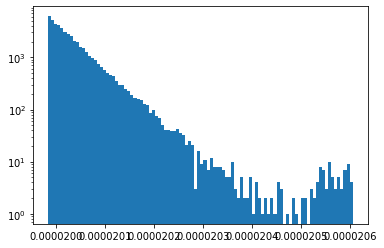

In [35]:
import matplotlib.pyplot as plt

probs = data[0][data[0] != 0]
print(len(probs))
plt.hist(probs, bins=100, log=True)

In [10]:
import json
with open("scores_first_ok.json", 'w') as f:
    json.dump([float(s) for s in scores], f)